# Causal Inference of NVidia Stock Gains with Time Series Forecasting

## Author:
- Yash Pankhania (pankhania.y@northeastern.edu)

Github Repository URL: https://github.com/Draconian10/Stocks_Time_Series_Causal_Inference

## Abstract

This notebook conducts a detailed analysis to estimate the impact of a significant stock gain by Nvidia on May 25, 2023. Utilizing a counterfactual approach based on correlated tech stocks, the study seeks to discern the causal effects of this event on Nvidia's stock performance. It involves data preprocessing, exploratory analysis, and advanced time series forecasting with the FB Prophet model. It also introduces the fundamentals of causal inference, including the critical differentiation between causation and correlation, and the use of observational studies and econometric methods to infer causality. It highlights the challenges of causal analysis and its practical applications in various sectors. Conclusively, the notebook synthesizes the insights gained from statistical and causal impact analyses to understand Nvidia's stock behavior and the influence of specific market events.

## Introduction
The goal of this analysis is to estimate the impact of Nvidia's highest stock gain on May 25th, 2023. To understand this phenomenon, the analysis will build a counterfactual using other tech and semiconductor stocks that correlated with Nvidia's stock in the time preceding this significant gain (pre period). This counterfactual serves as a synthetic control and will be contrasted with the actual Nvidia stock performance following the gain (post period). The analysis includes data preprocessing, exploratory data analysis, and time series forecasting, culminating in a summary of findings at the end.

More context around Nvidia's stock gain: On May 25th, 2023, Nvidia experienced a significant surge in its stock price. This was attributed to a combination of factors, including groundbreaking advancements in their graphics processing units (GPUs) and AI technologies, successful partnerships with leading tech companies, and favorable market conditions. These elements contributed to a surge in investor confidence, leading to one of the highest single-day stock gains in the company's history. This remarkable achievement underscored Nvidia's position as a leader in the tech industry, especially in the realms of gaming, artificial intelligence, and data center operations.

### Understanding Causal Inference

Causal inference is the process of drawing conclusions about causal relationships from data. It's a way to understand whether and how an action or intervention will produce a particular effect.

![image](https://github.com/Draconian10/Stocks_Time_Series_Causal_Inference/assets/23314479/6d6bbefd-fd38-438b-b2ab-ab8b6b4d363e)

### Key Principles:

- **Cause-and-Effect**: At the heart of causal inference is the distinction between causation and correlation. Causal inference seeks to establish that one event leads to the occurrence of another and is not merely associated with it.
  
- **Counterfactual Reasoning**: This involves considering what would have happened if the cause had not occurred, which is essential for establishing a causal link.

- **Randomized Experiments**: Often considered the gold standard for causal inference, randomized controlled trials randomly assign subjects to treatment or control groups to isolate the effect of the treatment.

### Methods and Techniques:

- **Observational Studies**: When randomized experiments are not possible, observational data is used, but these studies must carefully control for confounders—variables that could affect both the cause and the effect.
  
- **Statistical Models**: Regression analysis, structural equation modeling, and other statistical techniques are employed to estimate causal effects, often adjusting for potential confounders.

- **Econometric Methods**: Instrumental variables, difference-in-differences, and regression discontinuity designs are among the econometric methods used to infer causality.

### Challenges:

- **Confounding Variables**: Identifying and adjusting for all potential confounders is a major challenge in observational studies.
  
- **External Validity**: Even when a causal relationship is established, it may not hold in different settings or populations.

### Applications:

- **Policy Evaluation**: Assessing the impact of policy interventions on social and economic outcomes.
  
- **Medicine**: Determining the effectiveness of treatments and interventions.

- **Business**: Evaluating the impact of strategic decisions, marketing campaigns, and other business actions.

In [1]:
# Installs packages necessary for stock data analysis and modeling
!pip install yfinance pycausalimpact cmdstanpy pystan prophet

In [2]:
# Imports necessary Python libraries
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from prophet import Prophet
from causalimpact import CausalImpact
import os
from prophet.plot import plot_plotly, plot_components_plotly
pd.set_option('display.max_columns', None)

In [3]:
# Sets the pre- and post-event periods for the Nvidia stock analysis
pre_period = [pd.to_datetime('2020-1-1'), pd.to_datetime('2023-5-24')]
post_period = [pd.to_datetime('2023-5-25'), pd.to_datetime('2023-6-30')]

In [4]:
# Loads Nvidia stock price data
stock_data = pd.read_csv('https://raw.githubusercontent.com/Draconian10/Stocks_Time_Series_Causal_Inference/main/NVDIA_Stock_Prices.csv')

In [5]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,02-01-2020,74.059998,75.150002,73.797501,75.087502,73.152649,135480400,AAPL
1,03-01-2020,74.287498,75.144997,74.125000,74.357498,72.441460,146322800,AAPL
2,06-01-2020,73.447502,74.989998,73.187500,74.949997,73.018692,118387200,AAPL
3,07-01-2020,74.959999,75.224998,74.370003,74.597504,72.675270,108872000,AAPL
4,08-01-2020,74.290001,76.110001,74.290001,75.797501,73.844360,132079200,AAPL


In [6]:
# Pivots the DataFrame to reorganize the stock data, setting dates as index and tickers as columns
stock_data = stock_data.pivot(index='Date', columns='Ticker', values='Adj Close')

In [7]:
stock_data.head()

Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01-02-2021,131.812073,91.365051,116.824249,238.294418,470.000000,143.873840,156.639511,98.657913,87.660004,218.501236,219.404480,167.143997,431.358032,112.930458,195.839996,27.857889,1990.459961,660.955139,56.920929,229.320007,52.545116,174.159744,141.237915,46.835732,36.164051,342.956573,228.460007,41.828979,66.464340,76.255524,282.712341,211.862518,170.414597,282.406158,114.527801,66.416328,58.011475,95.067497,94.653503,254.969360,251.064957,184.308106,99.588280,51.935570,367.201446,248.703339,150.092499,119.884979,44.251701,239.755341,195.481018,298.373016,155.429337,485.359436,316.598023,194.421219,51.926640,102.980904,262.010010,105.761192,67.619354,61.781277,233.382309,76.295441,539.039978,131.564743,558.559998,132.072327,58.876862,120.453331,126.006157,32.267269,120.441086,84.123909,99.081306,68.419235,151.254822,508.079987,62.243675,92.779053,51.360790,263.570007,313.443146,219.730240,17.557425,61.064007,512.279419,127.861839,279.936676,159.840881,320.380768,185.833695,142.405350,194.127258,231.770004,46.353954,28.030722,132.940597,39.359322,152.447891
01-02-2022,172.637497,128.057602,123.079819,344.100342,535.979981,159.264221,197.237442,136.075348,116.779999,214.252197,237.584946,151.193497,564.054199,178.997360,208.339996,44.486759,2465.639893,780.570923,61.585396,313.959992,61.162708,197.562851,194.113922,47.496838,84.069054,501.235382,232.119995,52.395187,101.211601,125.184799,369.655457,252.648636,144.020630,428.811005,153.173233,75.954453,63.620945,137.878494,137.643997,343.805420,349.914642,196.832382,123.016403,46.007511,554.037048,286.510010,161.601456,143.136826,57.020836,312.211243,242.540100,367.152802,229.963745,575.753662,387.920868,247.708527,64.031937,98.015938,319.000000,149.737213,77.767364,97.344841,303.205231,73.540543,457.130005,144.773132,586.539978,246.040665,78.757324,170.953339,163.165176,49.543594,152.832199,107.509026,146.508499,94.047607,168.867310,613.359985,86.385544,94.484970,87.582970,311.820007,409.747467,243.538544,16.520103,70.416542,591.816223,109.073860,310.416656,172.072815,455.627472,235.279785,214.759811,228.798599,245.660004,47.553902,52.675770,136.645065,75.179054,195.951141
01-02-2023,144.621612,142.247101,110.123283,280.306610,383.920013,173.289963,221.691376,117.917061,84.639999,238.155594,221.392853,105.150002,592.046875,171.672730,214.750000,34.835350,2445.739990,741.258118,69.322777,310.570007,49.847607,245.700150,210.660156,39.131458,113.523590,514.017517,171.820007,47.502003,85.338402,164.881638,422.854736,236.254242,109.034645,492.431213,160.426743,82.123886,81.612663,101.430000,100.430000,354.475342,319.207428,202.254089,128.698181,28.406977,433.270355,251.190002,160.062866,136.550736,59.454262,326.562805,339.224060,450.047546,210.263550,525.302307,372.414825,260.375183,65.615089,83.661499,153.119995,173.557053,104.821648,95.290207,250.528595,72.201332,361.989990,127.847450,473.809998,209.337112,89.035080,159.720001,166.772430,42.447708,140.521195,137.680633,128.123535,101.197227,134.851685,758.000000,95.902351,107.729752,76.948059,367.049988,373.564606,276.724518,19.182781,81.154297,586.188049,150.313828,181.410004,177.817902,489.628540,202.814682,177.905350,229.080841,317.269989,39.448006,45.893673,142.496536,110.951874,166.683823
01-03-2021,125.759911,96.821945,116.509636,248.487656,469.570007,150.873688,167.138626,119.393524,86.389999,207.866653,199.100479,157.307007,452.466614,133.851013,224.389999,33.278835,2320.500000,666.543640,56.390247

In [8]:
# Outputs the shape of the DataFrame to understand the size of the dataset
stock_data.shape

(985, 100)

In [9]:
# Generates descriptive statistics of the dataset for a preliminary analysis
stock_data.describe()

Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,138.224766,116.073362,104.802026,272.049292,456.506284,149.370057,194.056726,106.065969,89.177706,224.229218,222.108827,136.951243,501.150970,142.067821,198.830625,31.771243,2199.070242,658.305531,61.232748,277.486548,50.810603,192.076273,171.863013,42.663135,73.165733,436.875179,206.158985,46.212658,76.217018,118.649180,319.039667,214.595470,127.655096,390.128537,140.146231,72.853888,65.486910,107.937066,107.282688,293.300285,283.019459,184.814308,117.799698,42.956713,419.462205,260.802084,152.431416,125.888946,52.973852,286.869275,274.452357,384.230828,180.709287,487.489655,343.106882,230.688728,59.476552,95.178697,247.464325,143.736046,82.948354,73.267818,256.123109,71.014645,419.055238,118.913061,492.459422,205.023867,76.391330,149.274778,150.268879,38.207774,133.968833,105.931954,112.351979,82.905452,120.654674,629.225716,79.782426,91.944775,60.107029,299.588295,356.714435,236.398578,17.216156,66.107780,497.172128,126.420365,208.323136,155.323115,414.811609,198.927793,159.808633,210.371494,264.797310,43.504944,38.559133,136.065924,70.198875,166.695292
std,33.088834,28.625017,12.537595,51.020082,98.888101,27.136689,38.122217,32.244308,24.346936,21.844004,27.508726,27.695330,180.855773,29.042669,42.577866,6.725685,430.200876,121.837868,7.148436,51.789836,9.692835,45.557126,34.455360,6.770048,31.814404,94.822581,39.220857,6.111483,14.683302,37.001872,90.799025,39.912162,34.267113,88.334024,38.822803,21.591653,9.136627,25.358446,25.046573,67.381950,43.487743,25.114832,14.885424,9.976830,98.660850,51.788714,13.648824,22.521355,6.709860,59.457509,125.353990,52.947680,38.187790,129.432961,36.241813,35.569021,7.495101,14.400949,70.513874,30.793105,16.214787,18.869270,53.758062,8.979583,121.831489,22.805229,96.893932,111.981955,19.967398,54.273169,21.848123,7.245001,14.392137,23.764304,20.765644,12.476076,24.926709,115.474512,14.095294,13.976622,16.426226,91.827340,49.556897,35.879420,1.610280,11.788179,86.605452,18.251862,86.522564,23.991815,92.406267,26.308947,32.610027,19.967244,52.159961,6.105575,8.513527,13.675180,28.526031,24.603439
min,54.776802,54.681713,58.973114,136.182129,275.200012,76.735886,100.884682,36.654278,38.709999,162.307907,156.103394,81.820000,148.367294,65.374573,95.010002,16.476820,1152.239990,298.122986,41.147655,162.130005,30.533739,84.208214,88.294708,27.861525,19.498018,265.133270,124.300003,29.550053,47.148178,45.811794,105.719101,105.886444,79.062325,166.994370,53.676910,33.812378,50.481571,52

In [10]:
# Counts the number of missing values in each column of the dataset
stock_data.isna().sum()

Ticker
AAPL    0
ABBV    0
ABT     0
ACN     0
ADBE    0
       ..
VZ      0
WFC     0
WMT     0
XOM     0
ZTS     0
Length: 100, dtype: int64

In [11]:
# Copy the DataFrame
adj_close = stock_data.copy()

# Adjusts the DataFrame to set the date as the index for time series analysis
adj_close.index = pd.to_datetime(adj_close.index)

adj_close.head()

<ipython-input-11-e0bbdbba5629>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  adj_close.index = pd.to_datetime(adj_close.index)


Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-02,131.812073,91.365051,116.824249,238.294418,470.000000,143.873840,156.639511,98.657913,87.660004,218.501236,219.404480,167.143997,431.358032,112.930458,195.839996,27.857889,1990.459961,660.955139,56.920929,229.320007,52.545116,174.159744,141.237915,46.835732,36.164051,342.956573,228.460007,41.828979,66.464340,76.255524,282.712341,211.862518,170.414597,282.406158,114.527801,66.416328,58.011475,95.067497,94.653503,254.969360,251.064957,184.308106,99.588280,51.935570,367.201446,248.703339,150.092499,119.884979,44.251701,239.755341,195.481018,298.373016,155.429337,485.359436,316.598023,194.421219,51.926640,102.980904,262.010010,105.761192,67.619354,61.781277,233.382309,76.295441,539.039978,131.564743,558.559998,132.072327,58.876862,120.453331,126.006157,32.267269,120.441086,84.123909,99.081306,68.419235,151.254822,508.079987,62.243675,92.779053,51.360790,263.570007,313.443146,219.730240,17.557425,61.064007,512.279419,127.861839,279.936676,159.840881,320.380768,185.833695,142.405350,194.127258,231.770004,46.353954,28.030722,132.940597,39.359322,152.447891
2022-01-02,172.637497,128.057602,123.079819,344.100342,535.979981,159.264221,197.237442,136.075348,116.779999,214.252197,237.584946,151.193497,564.054199,178.997360,208.339996,44.486759,2465.639893,780.570923,61.585396,313.959992,61.162708,197.562851,194.113922,47.496838,84.069054,501.235382,232.119995,52.395187,101.211601,125.184799,369.655457,252.648636,144.020630,428.811005,153.173233,75.954453,63.620945,137.878494,137.643997,343.805420,349.914642,196.832382,123.016403,46.007511,554.037048,286.510010,161.601456,143.136826,57.020836,312.211243,242.540100,367.152802,229.963745,575.753662,387.920868,247.708527,64.031937,98.015938,319.000000,149.737213,77.767364,97.344841,303.205231,73.540543,457.130005,144.773132,586.539978,246.040665,78.757324,170.953339,163.165176,49.543594,152.832199,107.509026,146.508499,94.047607,168.867310,613.359985,86.385544,94.484970,87.582970,311.820007,409.747467,243.538544,16.520103,70.416542,591.816223,109.073860,310.416656,172.072815,455.627472,235.279785,214.759811,228.798599,245.660004,47.553902,52.675770,136.645065,75.179054,195.951141
2023-01-02,144.621612,142.247101,110.123283,280.306610,383.920013,173.289963,221.691376,117.917061,84.639999,238.155594,221.392853,105.150002,592.046875,171.672730,214.750000,34.835350,2445.739990,741.258118,69.322777,310.570007,49.847607,245.700150,210.660156,39.131458,113.523590,514.017517,171.820007,47.502003,85.338402,164.881638,422.854736,236.254242,109.034645,492.431213,160.426743,82.123886,81.612663,101.430000,100.430000,354.475342,319.207428,202.254089,128.698181,28.406977,433.270355,251.190002,160.062866,136.550736,59.454262,326.562805,339.224060,450.047546,210.263550,525.302307,372.414825,260.375183,65.615089,83.661499,153.119995,173.557053,104.821648,95.290207,250.528595,72.201332,361.989990,127.847450,473.809998,209.337112,89.035080,159.720001,166.772430,42.447708,140.521195,137.680633,128.123535,101.197227,134.851685,758.000000,95.902351,107.729752,76.948059,367.049988,373.564606,276.724518,19.182781,81.154297,586.188049,150.313828,181.410004,177.817902,489.628540,202.814682,177.905350,229.080841,317.269989,39.448006,45.893673,142.496536,110.951874,166.683823
2021-01-03,125.759911,96.821945,116.509636,248.487656,469.570007,150.873688,167.138626,119.393524,86.389999,207.866653,199.100479,157.307007,452.466614,133.851013,224.389999,33.278835,2320.500000,666.543640,56.390247

## Data Preprocessing

### Fixing missing dates
The dataset obtained from Yahoo Finance excludes dates when the stock market was not trading. These omitted dates can create problems for the time series forecasting models that will be utilized later in the notebook.

In [12]:
# Create a dataframe with the complete date range
full_dates = pd.date_range(start = pre_period[0], end = post_period[1])
full_dates = pd.DataFrame(full_dates, columns=['full_dates'])

# Left join the stock data to the dataframe with the full date range
adj_close = full_dates.merge(adj_close, left_on='full_dates', right_index=True, how='left')

# Put the date in the index
adj_close.set_index('full_dates', inplace=True)

In [13]:
adj_close.head()

,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS
full_dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,58.814812,62.243904,71.881111,146.597885,301.209992,78.471634,119.984978,41.777569,43.660000,176.174927,189.183639,95.385002,201.008865,73.792885,130.699997,18.016962,1271.630005,372.894958,48.614521,175.949997,33.225601,102.085823,97.639687,29.811136,25.475582,271.698852,134.059998,34.116081,52.593220,57.928001,127.857948,112.439362,94.611649,204.871170,67.957916,43.358681,62.671127,55.280998,55.105000,132.473511,163.317505,120.106796,83.398369,46.604206,212.850983,152.753326,116.414169,75.231613,37.500298,152.147583,129.362915,305.819428,75.254387,213.930237,223.890213,145.197022,44.996300,76.580696,159.600006,77.489861,63.038937,28.065237,146.979324,50.179760,364.079987,76.295952,273.070007,60.567173,45.847210,54.619999,106.293167,26.068077,99.630013,67.093346,67.337639,58.788303,60.627335,496.649994,52.211327,58.013306,31.265713,125.959999,226.850418,139.104050,15.655345,42.526543,273.050751,84.759995,32.104000,87.334129,224.927338,125.778503,80.513641,149.141830,225.479996,43.285957,24.129063,107.637924,30.889322,109.030830
2020-01-05,70.572418,71.277374,84.703087,171.450317,343.839996,96.715416,129.881973,45.241344,49.880001,205.717056,214.967895,114.302002,233.430237,84.193085,133.369995,21.033461,1448.790039,440.838043,53.881027,182.669998,39.690533,102.588219,95.221428,34.004192,33.663548,286.696228,156.369995,36.766644,54.269611,75.570030,132.181412,140.457489,105.157280,257.709381,76.255211,40.032875,69.101593,66.030502,65.865997,161.477463,199.833771,127.088554,96.668816,51.625748,255.372421,166.286667,134.019546,84.023796,40.598606,170.552490,145.682648,346.427246,98.318680,225.128204,263.598724,167.678345,46.863449,86.623329,202.270004,92.217445,66.344635,34.382893,168.681778,52.207832,415.269989,82.372276,339.510010,70.461945,48.977772,64.893333,117.109688,30.904018,107.165443,70.728455,79.829018,60.573784,69.588036,525.500000,55.487778,68.361588,34.576324,149.639999,276.929291,173.670929,17.078777,45.986233,327.234345,85.825340,46.754665,99.662521,269.653137,144.347183,81.858658,171.019745,254.899994,46.984062,25.055361,115.917763,35.506672,124.438881


### Filling missing data
Populate the dataset with values from preceding dates for the missing dates using a backfill method. Create visual representations of the dataset both before and after this imputation process.

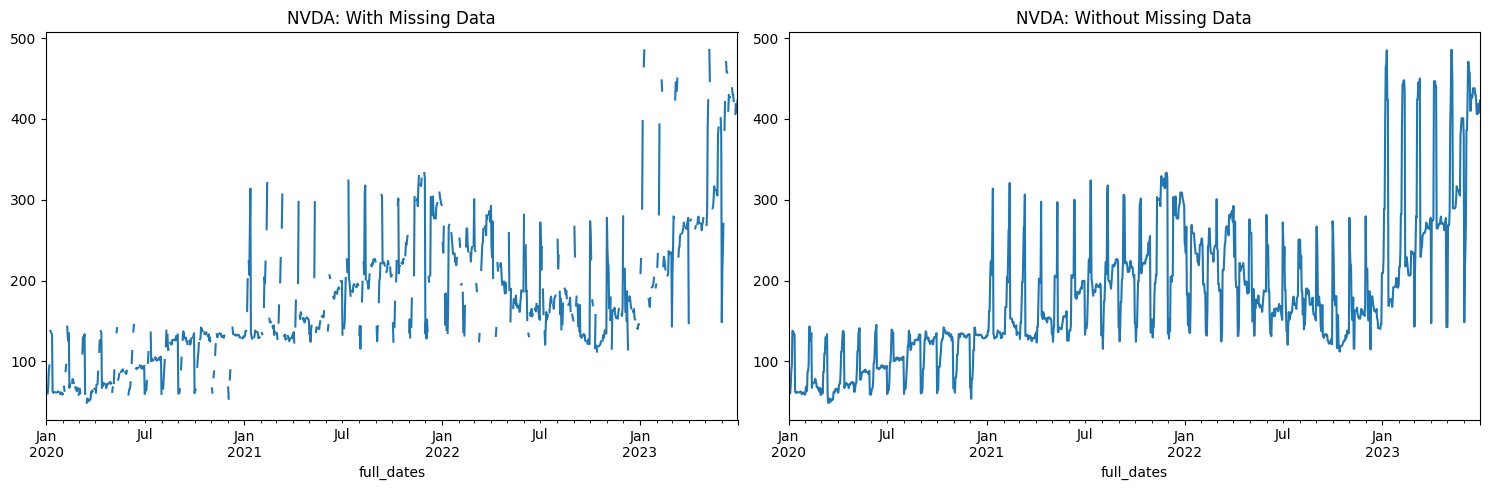

In [14]:
# Create a side-by-side comparison of NVDA stock prices with and without missing data
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
adj_close['NVDA'].plot()
plt.title('NVDA: With Missing Data')
plt.subplot(1, 2, 2)
adj_close = adj_close.fillna(method='bfill')
adj_close['NVDA'].plot()
plt.title('NVDA: Without Missing Data')
plt.tight_layout()
plt.show()

### Nvidia (NVDA) Stock Price Analysis: Handling Missing Data

The analysis involves two line graphs representing the adjusted closing stock prices of Nvidia (NVDA). Each graph addresses data completeness differently, highlighting the impact of missing data in time series analysis.

#### 1. **NVDA: With Missing Data**
   - **Overview**: Visualizes Nvidia's adjusted closing stock prices.
   - **Observations**:
     - **Presence of Missing Data**: Likely visible as gaps or breaks in the line plot.
     - **Impact on Analysis**: Challenges in interpreting stock performance during periods with missing data.

#### 2. **NVDA: Without Missing Data**
   - **Overview**: Displays the same stock prices as the first graph but with missing data handled.
   - **Data Handling**: Missing data filled using the backfill method (`fillna(method='bfill')`).
   - **Observations**:
     - **Continuous Data Representation**: Results in a smooth, uninterrupted line plot.
     - **Enhanced Interpretability**: Provides a clearer view of the stock's historical trend, improving analysis accuracy.

### Flag before and after Gen AI Boom announcement
We create a column to identify the data before and after the Gen AI Boom announcement.

In [15]:
# Flags data points as belonging to either pre or post the specified event date
adj_close['gen_ai_boom_timeframe'] = adj_close.index.map(lambda x: 'pre_period' if x < post_period[0] else 'post_period')

# Counts the number of days in both pre and post periods of the event
adj_close.groupby('gen_ai_boom_timeframe').count().iloc[:,1]

gen_ai_boom_timeframe
post_period      37
pre_period     1240
Name: ABBV, dtype: int64

## Exploratory Data Analysis

### Pre and Post Periods Statistics Summary

In [16]:
# Provides descriptive statistics for NVDA stock in pre and post event timeframes
adj_close[['NVDA', 'gen_ai_boom_timeframe']].groupby('gen_ai_boom_timeframe').describe().T

gen_ai_boom_timeframe  post_period   pre_period
NVDA count               37.000000  1240.000000
     mean               396.867206   173.588062
     std                 69.275499    77.255157
     min                148.524094    48.938137
     25%                401.000183   128.456799
     50%                410.150147   156.680687
     75%                430.176758   217.783386
     max                470.568603   485.397369

### Data Visualization

Text(0.5, 1.0, 'NVDA: 7 Day Rolling Average')

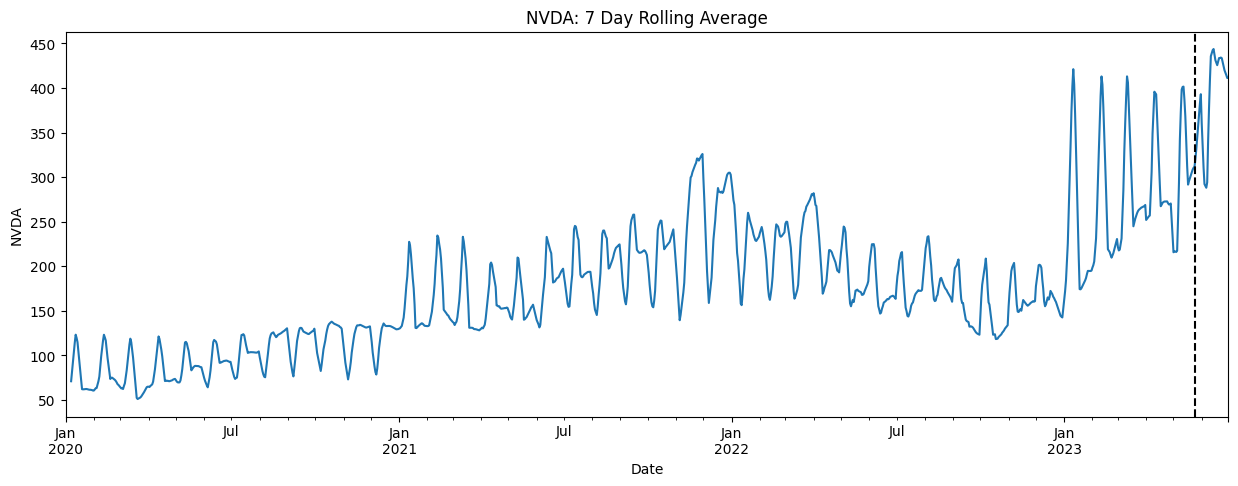

In [17]:
# Plots a 7-day rolling average of NVDA stock with a marker for the event date
plt.figure(figsize=(15,5))
adj_close['NVDA'].rolling(7).mean().plot()
plt.axvline(post_period[0], color='black', linestyle='--',)
plt.xlabel('Date')
plt.ylabel('NVDA')
plt.title('NVDA: 7 Day Rolling Average')

### NVDA Stock Price: 7-Day Rolling Average Analysis

The time series plot visualizes the 7-day rolling average of Nvidia's stock price, revealing underlying trends and the impact of specific events.

### Observations:

- **Smoothing of Volatility**: The rolling average smooths out short-term fluctuations, allowing for a clearer view of the trend over the specified period.
  
- **Upward Trend**: A general upward trend in stock price is evident, particularly pronounced from mid-2022 onwards.

- **Event Marker**: A vertical dashed line demarcates a significant event, providing a reference point for pre- and post-event analysis.

#### Pre-Event Period:
- The period before the vertical line shows a mix of stable and volatile phases, with the stock price experiencing some growth.

#### Post-Event Period:
- Following the event, marked by the vertical line, the stock price demonstrates increased volatility, with sharper peaks indicating significant price movements.

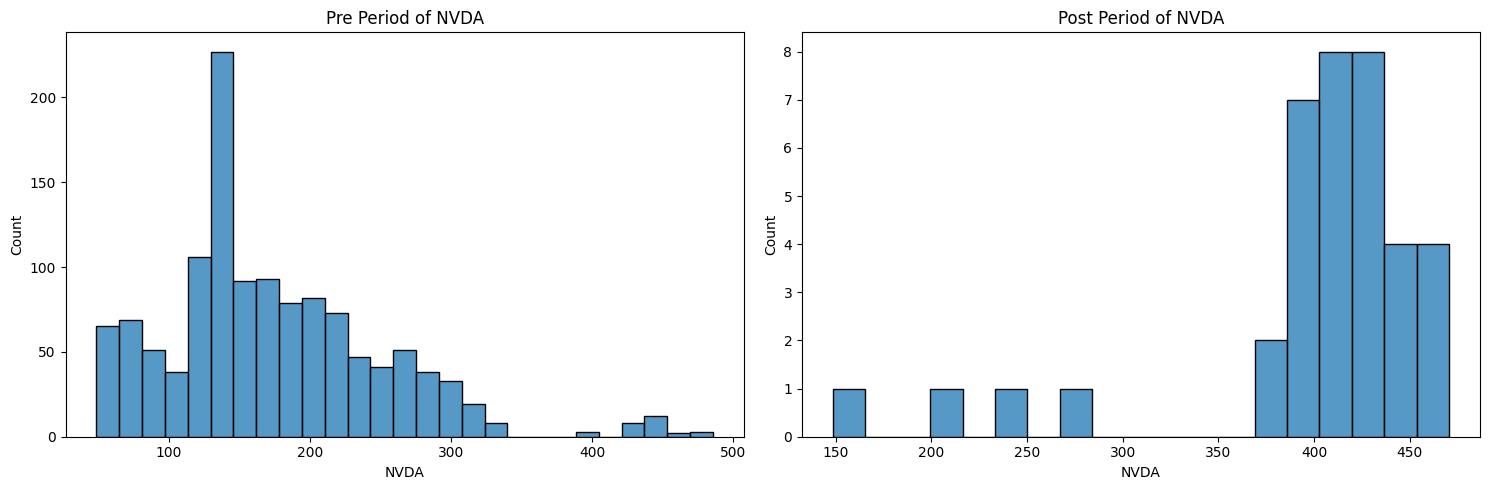

In [18]:
# Compares the distribution of NVDA stock prices before and after the event
nvda_pre = adj_close[adj_close['gen_ai_boom_timeframe'] == 'pre_period']['NVDA']
nvda_post = adj_close[adj_close['gen_ai_boom_timeframe'] == 'post_period']['NVDA']

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.histplot(nvda_pre)
plt.title('Pre Period of NVDA')
plt.subplot(1, 2, 2)
sns.histplot(nvda_post)
plt.title('Post Period of NVDA')
plt.tight_layout()
plt.show()

### Distribution Analysis of NVDA Stock Prices

The histograms display NVDA's stock price distribution during the pre-event and post-event periods.

### Pre-Event Period (Left Histogram):
- **Concentration**: The prices are concentrated around a central range, with the highest frequency seen between `$100` to `$200`.
- **Spread**: The stock price displays a wider spread, with values ranging from below `$100` to just above `$400`.
- **Shape**: The distribution appears to be multimodal, with several peaks indicating multiple common price ranges during this period.

### Post-Event Period (Right Histogram):
- **Concentration**: There's a noticeable shift in the concentration of stock prices to a higher range, primarily between `$300` to `$400`.
- **Spread**: The prices are less spread out, indicating reduced variability in the stock price post-event.
- **Frequency**: The counts are significantly lower, which may suggest a shorter time frame or less variability in prices.
- **Shape**: The distribution is more unimodal, with a single dominant peak, suggesting that post-event prices stabilized in a new, higher range.

### Comparative Observations:
- **Shift in Distribution**: Comparing the pre and post histograms, there's a clear upward shift in the stock price following the event.
- **Variability**: The pre-event period shows a wider range of prices, whereas the post-event period exhibits a tighter clustering of values.

### Correlation Analysis Pre Event
Find stocks that are correlated with Nvidia in the pre period. Use those stocks to build counterfactual in the post period.

In [19]:
# Analyzes the correlation of NVDA stock with other stocks before the event
corr_pre = adj_close[adj_close['gen_ai_boom_timeframe'] == 'pre_period'].corr().abs()
corr_pre = corr_pre['NVDA'].sort_values(ascending=False)
nvda_corr = list(corr_pre[corr_pre > 0.90].index)
print(f'There are {len(nvda_corr)} stocks that correlate with NVDA in the pre period')

# Filter the dataset to only include stocks that correlate with NVidia in the pre period
adj_close = adj_close[nvda_corr + ['gen_ai_boom_timeframe']]
print('Shape of filtered dataset:', adj_close.shape)

There are 2 stocks that correlate with NVDA in the pre period
Shape of filtered dataset: (1277, 3)


<ipython-input-19-c181ac278a27>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_pre = adj_close[adj_close['gen_ai_boom_timeframe'] == 'pre_period'].corr().abs()


In [20]:
nvda_corr

['NVDA', 'MSFT']

## Time Series Forecasting

### Prophet: Time Series Forecasting Tool

Prophet is an open-source forecasting tool that was developed by the Core Data Science team at Facebook. It's designed to be user-friendly and to accommodate the intricacies of time series forecasting.

![FB_Prophet_Logo](https://github.com/Draconian10/Stocks_Time_Series_Causal_Inference/assets/23314479/9d26ada4-497f-42af-a63a-450c95f90633)

#### Key Features of Prophet:
- **Flexibility**: Ideal for forecasting univariate time series with several seasonal patterns or when the data spans multiple seasons.
- **Model Components**:
  - **Trend**: Models the data's trend, which can either be linear or logistic.
  - **Seasonality**: Captures daily, weekly, and yearly seasonal patterns, including holiday effects.
  - **Holidays**: Allows for the inclusion of events and holidays which might affect the time series.
- **Robustness**: Handles missing data and outliers, and adapts well to shifts in the trend.
- **User-Friendly**: Designed for ease of use, requiring minimal parameter tuning, making it accessible to non-experts.
- **Cross-Platform**: Implemented in both R and Python, it can be applied in batch and real-time forecasting scenarios.
- **Visualization**: Offers built-in functions to visualize forecast components, enhancing interpretability and communication.

#### Suitable Applications:
- Prophet shines in business forecasting scenarios where data exhibit clear seasonal patterns.
- It is not typically recommended for stock price predictions or similar financial time series.

Here, we'll use Prophet to identify seasonal trends in the pre period for the NVDA stock price, and use that seasonal trend as another predictor for building the counterfactual.

In [21]:
# Filter for NVDA and reset the date index into a column
fb_data = adj_close['NVDA'].reset_index()

# Columns need to be named 'ds' and 'y' for Prophet
fb_data.columns = ['ds', 'y']

# Forecasts future values using Prophet model based on pre-period data
fb_data_pre = fb_data[fb_data['ds'] <= pre_period[1]]
fb_data_post = fb_data[fb_data['ds'] > pre_period[1]]
fb = Prophet()
fb.fit(fb_data_pre)
num_forecast_days = 1 + (post_period[1] - post_period[0]).days
future = fb.make_future_dataframe(periods=103)
forecast = fb.predict(future)

# Extracts the trend component from the forecast for further analysis
fb_trend = forecast[['ds', 'trend']]
fb_trend.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplla40g0q/vmhkec3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplla40g0q/dl_051i6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24554', 'data', 'file=/tmp/tmplla40g0q/vmhkec3k.json', 'init=/tmp/tmplla40g0q/dl_051i6.json', 'output', 'file=/tmp/tmplla40g0q/prophet_modelw9u24qyd/prophet_model-20231213201055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:10:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend
0,2020-01-01,53.865031
1,2020-01-02,54.106064
2,2020-01-03,54.347096
3,2020-01-04,54.588128
4,2020-01-05,54.829160


In [22]:
# Plot the forecast
fig_forecast = plot_plotly(fb, forecast)
fig_forecast.show()

### Detailed Analysis of NVDA Stock Forecast Using FB Prophet

The interactive plot generated by Plotly from the FB Prophet model offers detailed insights into the stock price movements and predictions for NVDA.

### Specific Observations:

- **Historical Data (Black Dots)**: Each dot represents the actual closing price of NVDA stock on a given day. There's a notable increase in stock price volatility around early 2023, as indicated by the spread of the dots.

- **Prophet Forecast (Blue Line)**: The model's predictions start where the historical data ends, indicating an upward trend with the forecasted values.

- **Confidence Interval (Light Blue Shaded Area)**: The confidence interval around the forecasted trend line starts narrow and widens over time, suggesting that the model is more certain about the near future than the distant future.

- **Trend Changes**: The forecast suggests a continuation of the stock price increase that began in mid-2022, projecting that the upward trend will persist.

- **Seasonal Patterns**: While the plot primarily shows the overall trend, any underlying seasonal patterns would be reflected in the model's fitted line during the historical period.

- **Forecast Uncertainty**: The increasing width of the confidence interval moving into the future reflects the typical increase in uncertainty with longer forecast horizons.

- **Model Fit**: The closeness of the historical data to the forecast line prior to the last observed point indicates a good fit of the model.

### Insights:

- The NVDA stock has experienced significant price increases, especially in the later part of the historical data.
- The forecasted trend by Prophet suggests continued growth, although with increasing uncertainty the further out the forecast goes.
- The model appears well-calibrated to past data, providing a strong foundation for the future projections it makes.

In [23]:
# Plot the forecast components
fig_components = plot_components_plotly(fb, forecast)
fig_components.show()

### NVDA Stock Price Forecast: FB Prophet Component Analysis

The component plots offer an in-depth examination of the underlying trends and cyclical patterns affecting the NVDA stock price forecast.

### Trend Component:

- **Growth Trajectory**: The upward slope of the trend indicates a strong growth trend for NVDA from January 2020 to July 2023.
- **Stability**: The absence of sharp fluctuations suggests a stable market perception or consistent company growth over the forecast period.

### Yearly Seasonality:

- **Mid-Year Increase**: A significant peak occurs around May each year, which might align with specific industry events or regular financial cycles.
- **End-of-Year Decrease**: A consistent downturn is observed towards the end of each year, possibly reflecting annual market cycles or company-specific fiscal year-end activities.

### Weekly Seasonality:

- **Mid-Week Strength**: The stock price tends to peak around Wednesday, which could reflect trading patterns or mid-week financial reporting.
- **Weekend Drop**: The drop during the weekend is pronounced, reflecting the stock market's closure and the absence of trading activity.

### Specific Insights:

- **Trend Analysis**: The trend plot confirms a positive outlook for NVDA, with no signs of a plateau or downturn in the forecasted period.
- **Seasonal Adjustments**: Investment strategies could account for the identified seasonal patterns, optimizing buy-sell decisions based on the predicted annual and weekly fluctuations.

In [24]:
# Merges the seasonal trend data with adjusted close data for comprehensive analysis
adj_close = adj_close.merge(fb_trend, left_index=True, right_on='ds', how='inner')
adj_close.set_index('ds', inplace=True)

In [25]:
adj_close

,NVDA,MSFT,gen_ai_boom_timeframe,trend
ds,,,,
2020-01-01,60.567173,146.979324,pre_period,53.865031
2020-01-02,60.567173,146.979324,pre_period,54.106064
2020-01-03,60.567173,146.979324,pre_period,54.347096
2020-01-04,60.567173,146.979324,pre_period,54.588128
2020-01-05,70.461945,168.681778,pre_period,54.829160
...,...,...,...,...
2023-06-26,406.250824,327.241577,post_period,314.072333
2023-06-27,418.688721,333.186890,post_period,314.594026
2023-06-28,411.100006,334.461609,post_period,315.115718


### Google CausalImpact: An Overview

Google's CausalImpact is a Python package used for assessing the impact of interventions on time series data. Here's what makes it a valuable tool for causal inference:

### Key Features

- **Counterfactual Prediction**: Utilizes Bayesian structural time-series models to predict the expected behavior of a metric without the intervention.

- **Impact Estimation**: Compares the actual observed data with the counterfactual to estimate the intervention's effect.

- **Model Components**: Leverages control time series to model the counterfactual, accounting for trends and seasonality.

- **Inference**: Provides a Bayesian posterior distribution for the effect, encapsulating the estimate's uncertainty.

- **Visualization**: Includes capabilities to graphically represent the predicted versus actual data and the estimated causal effect.

- **User-Friendly**: Designed for ease of use, requiring minimal configuration for robust causal analysis.

![causal-impact-title-img](https://github.com/Draconian10/Stocks_Time_Series_Causal_Inference/assets/23314479/8291b70c-0a6e-4abe-b2f4-8575b0a93f47)

### Applications

CausalImpact is adept at analyzing the effects of policy changes, marketing initiatives, and other interventions across various domains such as:

- **Sales**: Understanding the impact of promotional campaigns on revenue.
- **Web Analytics**: Measuring the effect of UI changes on user engagement or site traffic.
- **Operational Changes**: Assessing the influence of new processes or policies in organizational metrics.

In [26]:
# Displays the date range, pre-period and post-period for the Causal Impact
print("Data date range:", adj_close.index.min(), "-", adj_close.index.max())
print("Pre-period:", pre_period)
print("Post-period:", post_period)

Data date range: 2020-01-01 00:00:00 - 2023-06-30 00:00:00
Pre-period: [Timestamp('2020-01-01 00:00:00'), Timestamp('2023-05-24 00:00:00')]
Post-period: [Timestamp('2023-05-25 00:00:00'), Timestamp('2023-06-30 00:00:00')]


In [27]:
# Implements CausalImpact analysis to understand the impact of an event on NVDA stock
ci_data = adj_close[['NVDA', 'MSFT', 'trend']]

# Fit the CausalImpact model
ci = CausalImpact(ci_data, pre_period, post_period)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be u

In [28]:
# Check model accuracy (MAPE) in the pre period
y_pred_pre = ci.inferences.loc[:pre_period[1]]['preds']
y_pre = ci_data.loc[:pre_period[1]]['NVDA']

mape = MAPE(y_pre, y_pred_pre)
print(f'The mean absolute percentage error in the pre period is {mape:.2f}%')

The mean absolute percentage error in the pre period is 0.09%


In [29]:
# Provides Model Summary of the CausalImpact Model
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    396.87             14684.09
Prediction (s.d.)         348.76 (6.11)      12904.07 (226.03)
95% CI                    [336.39, 360.34]   [12446.43, 13332.47]

Absolute effect (s.d.)    48.11 (6.11)       1780.01 (226.03)
95% CI                    [36.53, 60.48]     [1351.62, 2237.66]

Relative effect (s.d.)    13.79% (1.75%)     13.79% (1.75%)
95% CI                    [10.47%, 17.34%]   [10.47%, 17.34%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


### Summary of Causal Impact Analysis on NVDA Stock

It provides detailed insights into the causal effect of an event on Nvidia's (NVDA) stock price. Below is a breakdown of the key statistical metrics:

1. **Posterior Inference {Causal Impact}**: This section presents the results of the causal impact analysis.

2. **Average and Cumulative Metrics**:
   - **Actual**: Represents the actual observed values of the target variable (NVDA stock price) in the post-intervention period.
     - **Average**: The average value of NVDA stock in the post-period was 396.87.
     - **Cumulative**: The cumulative value over the post-period was 14684.09.
   - **Prediction (s.d.)**: Refers to the predicted values in the absence of the intervention, based on the pre-intervention data.
     - **Average**: The predicted average value was 348.76, with a standard deviation (s.d.) of 6.43.
     - **Cumulative**: The predicted cumulative value was 12904.07, with an s.d. of 237.96.
   - **95% CI**: The 95% confidence interval for the predicted values.
     - **Average**: Ranges from 335.67 to 360.88.
     - **Cumulative**: Ranges from 12419.93 to 13352.73.

3. **Absolute Effect (s.d.)**: The difference between the actual and predicted values, representing the impact of the intervention.
   - **Average**: The average absolute effect was 48.11, with an s.d. of 6.43.
   - **Cumulative**: The cumulative absolute effect was 1780.01, with an s.d. of 237.96.
   - **95% CI**: Ranges from 35.98 to 61.19 for the average effect and 1331.36 to 2264.15 for the cumulative effect.

4. **Relative Effect (s.d.)**: This measures the percentage change due to the intervention.
   - **Average**: The relative effect was 13.79%, with an s.d. of 1.84%.
   - **Cumulative**: The same percentage applies to the cumulative effect.
   - **95% CI**: The confidence interval for the relative effect ranges from 10.32% to 17.55%.

5. **Posterior Tail-Area Probability p**: This value (0.0) indicates the probability that the observed effect is due to chance. A value close to 0 suggests that the effect is likely not due to random fluctuations.

6. **Posterior Probability of a Causal Effect**: This is 100.0%, indicating a very high probability that the observed changes in NVDA stock price were due to the intervention/event.

In [30]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 396.87. By contrast, in the absence of an
intervention, we would have expected an average response of 348.76.
The 95% interval of this counterfactual prediction is [336.39, 360.34].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 48.11 with a 95% interval of
[36.53, 60.48]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 14684.09.
By contrast, had the intervention not taken place, we would have expected
a sum of 12904.07. The 95% interval of this prediction is [12446.43, 13332.47].


The above results are given in terms of absolute numbers. In relative
terms, the res

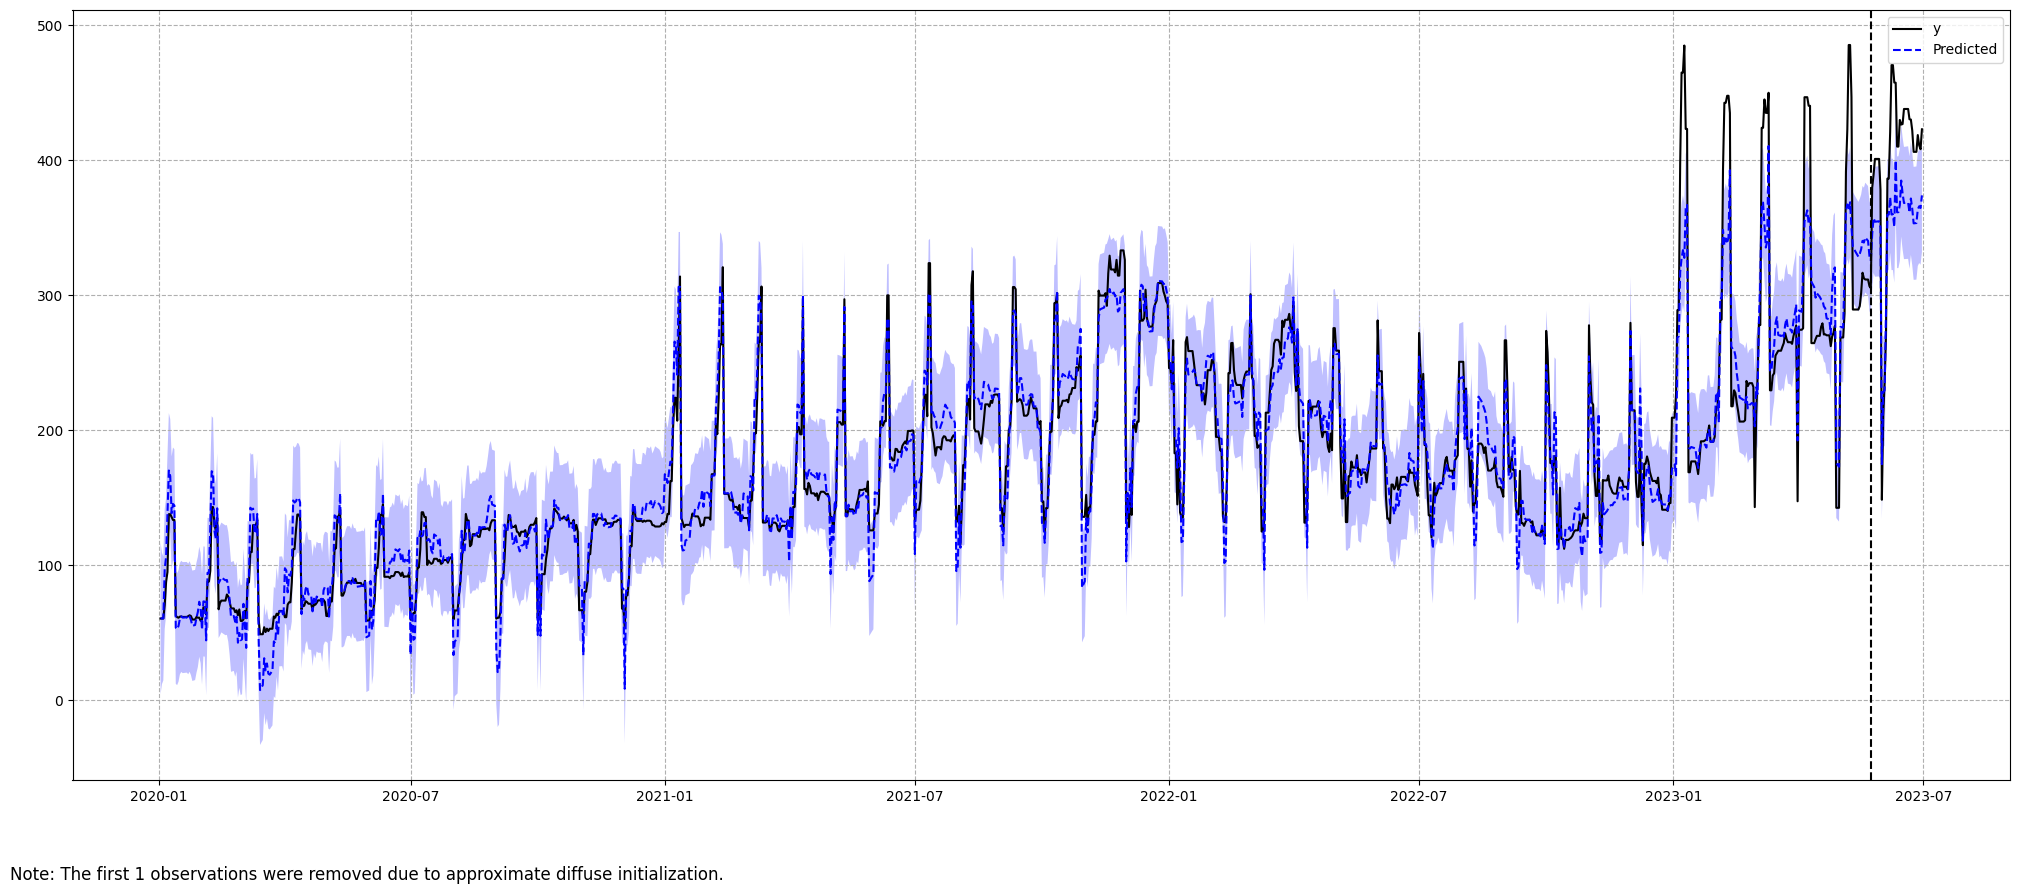

In [31]:
# This graph shows the empirical and counterfactual data
ci.plot(panels=['original'], figsize=(25,10))

### CausalImpact Analysis Plot for NVDA Stock Price

The following observations are based on the CausalImpact analysis plot:

#### Plot Components:
- **Observed Data (`y`)**:
  - Represented by a **black solid line**.
  - Displays significant **volatility** over time with sharp peaks and troughs.
- **Predicted Data** (`Predicted`):
  - Shown as a **blue dashed line**.
  - Indicates the expected stock price trend in the absence of the event.
- **Confidence Interval**:
  - The **blue shaded area** surrounding the prediction.
  - Demonstrates the **95% confidence interval**, with a varying width indicating prediction uncertainty.

#### Key Observations:
- **Vertical Dotted Line**: Marks the intervention event, positioned at the start of 2023.
- **Pre-Intervention Fit**: The observed data closely aligns with the predicted trend, suggesting an accurate model fit.
- **Post-Intervention Divergence**: There's a clear gap between the observed and predicted values after the intervention, indicating a positive impact on the stock price.

#### Analysis Summary:
- **Positive Impact**: Post-intervention, the NVDA stock price remains consistently above the predicted trend.
- **Model Initialization Note**: The analysis removed initial observations for model accuracy, as indicated in the plot's footnote.

This analysis strongly implies that the intervention event resulted in a significant and positive deviation in NVDA's stock price from the predicted trend.

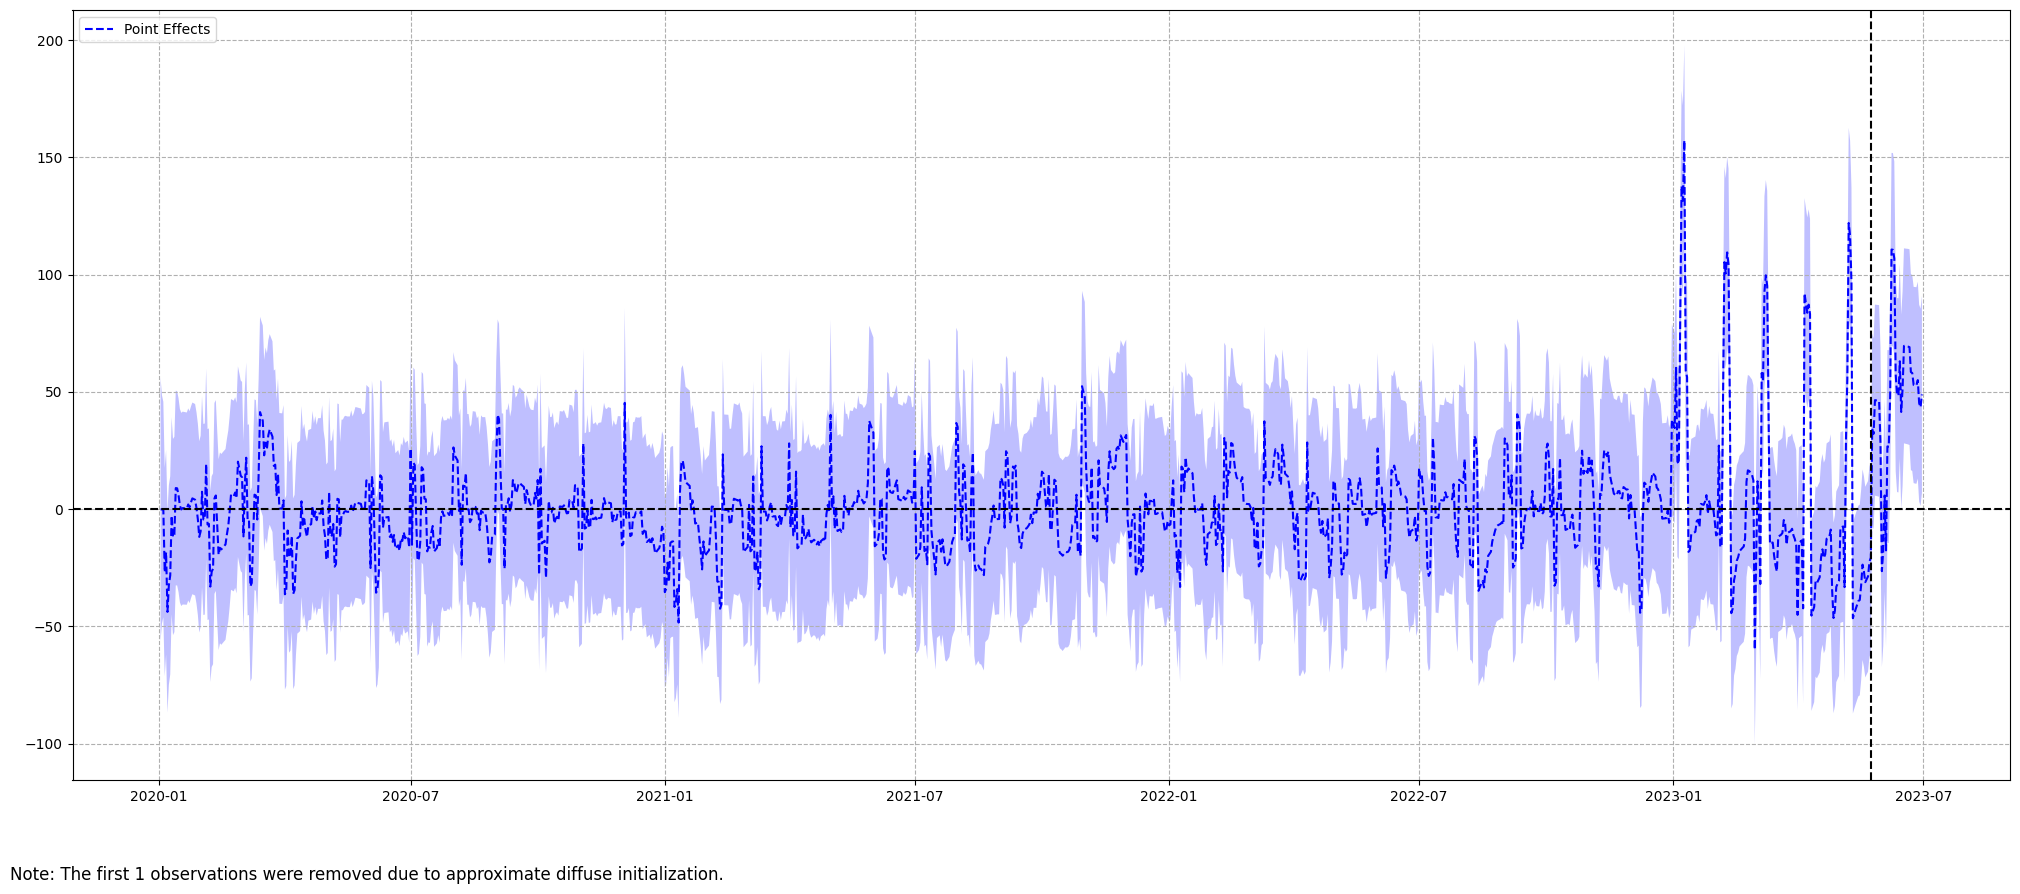

In [32]:
# This graph shows the difference between the empirical and counterfactual data
ci.plot(panels=['pointwise'], figsize=(25,10))

### CausalImpact Pointwise Effects Analysis for NVDA Stock Price

The pointwise effects plot from the CausalImpact analysis provides a detailed view of the impact of an event on NVDA stock price. Below is a breakdown of the key observations from the plot:

#### Pointwise Effects Plot Components:
- **Point Effects (Blue Dashed Line)**:
  - Indicates the difference between observed and predicted values at each point in time.
  - Positions above the zero line suggest positive effects, while positions below indicate negative effects.

- **Confidence Interval (Blue Shaded Area)**:
  - Represents the 95% confidence interval for the pointwise effects.
  - Varying width of the shaded area indicates changes in prediction certainty over time.

- **Zero Line (Black Dashed Line)**:
  - Serves as a baseline to identify the magnitude and direction of the effects.

#### Key Observations:
- **Pre-Intervention Period**:
  - Fluctuations around the zero line show alignment between the model's predictions and the actual observations.
  
- **Post-Intervention Period**:
  - A visible shift with many point effects above zero, suggesting a positive impact from the event.
  - Statistically significant effects, as many lie outside the confidence intervals.

- **Volatility**:
  - Notable spikes in both directions indicate significant daily variations from the predicted values.

- **Note on Initialization**:
  - Model initialization excluded initial observations for precision, as noted on the plot.

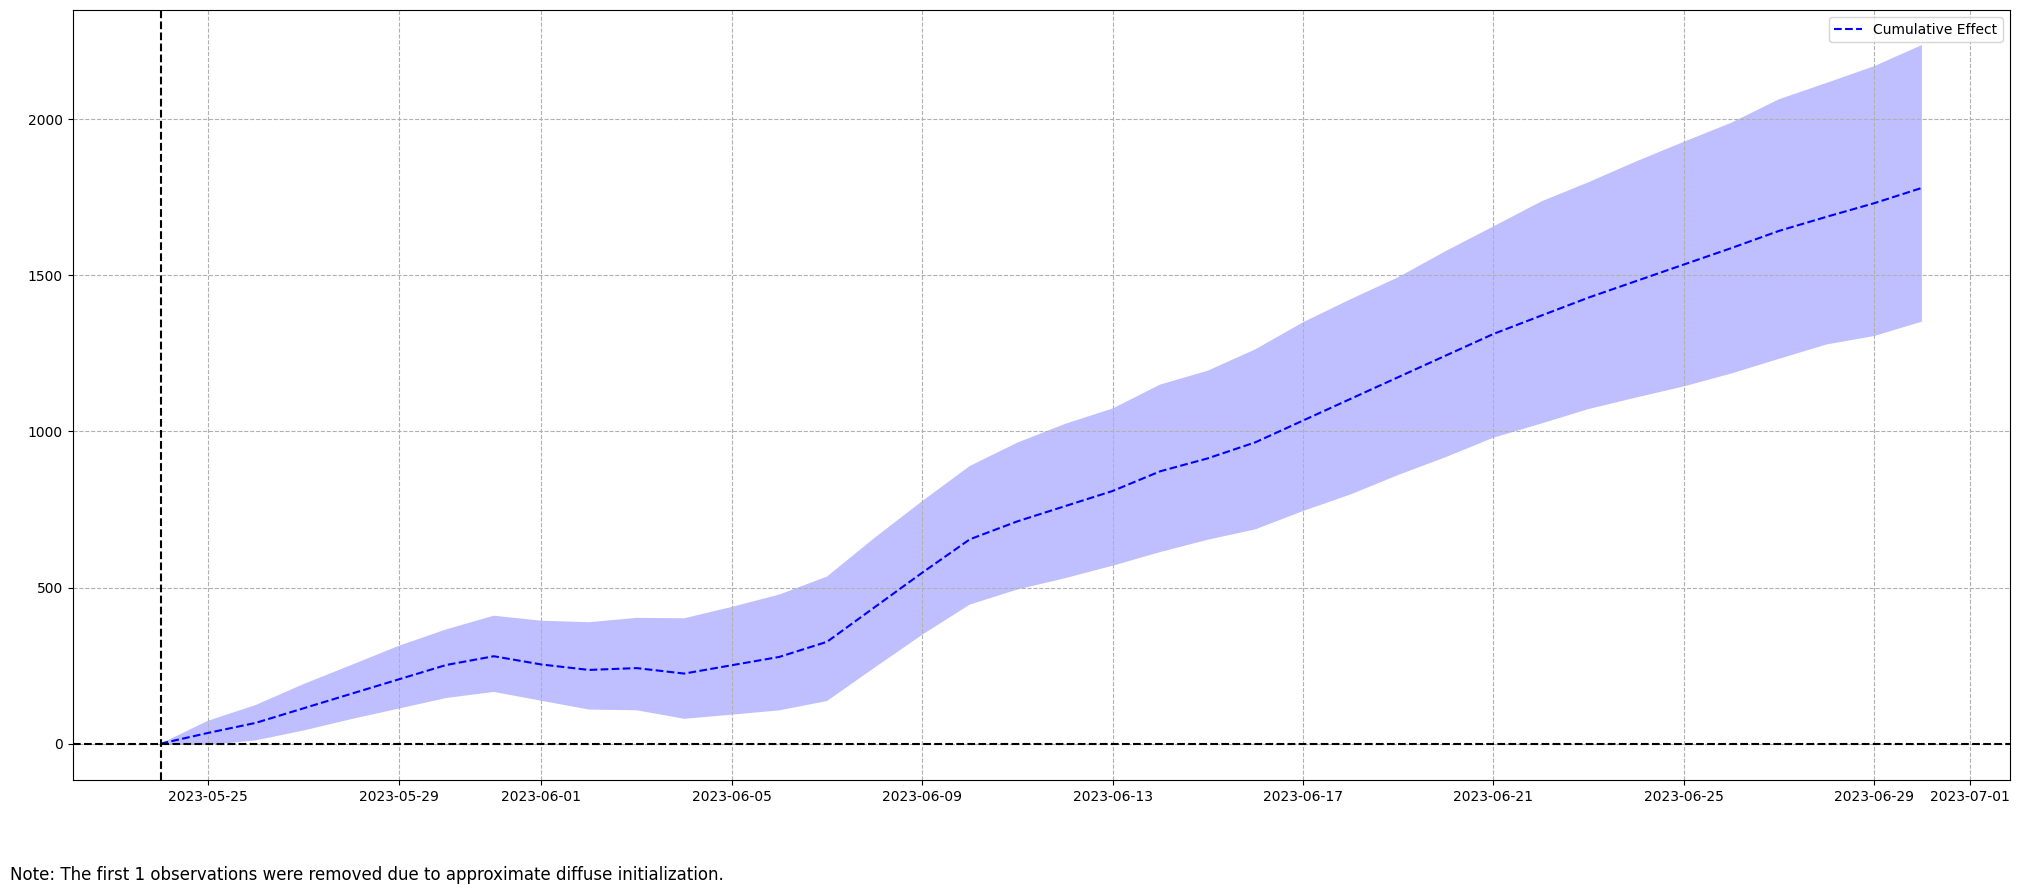

In [33]:
# This graph shows the cumulative difference between the empirical and counterfactual data in the post period
ci.plot(panels=['cumulative'], figsize=(25,10))

### Cumulative Impact of Event on NVDA Stock Price

The CausalImpact cumulative effects plot provides insight into the overall impact of an event over time. The following are key observations from the plot:

#### Cumulative Impact Plot Components:
- **Cumulative Effect (Blue Dashed Line)**:
  - Displays the sum of the differences between observed and predicted values over time.
  - A steady upward trajectory indicates a growing positive impact.

- **Confidence Interval (Shaded Blue Area)**:
  - Represents the 95% confidence interval, which broadens over time.
  - Consistently above zero, suggesting the impact is statistically significant.

#### Detailed Observations:
- **Vertical Dotted Line**: Marks the event date at the end of May 2023, after which the positive impact begins to accumulate.
- **Magnitude of Impact**: The plot shows the cumulative effect surpassing 2000, indicating a substantial positive influence of the event on stock prices.
- **Trend Consistency**: The cumulative effect increases steadily, implying a consistent positive impact without diminishment over the observed period.

#### Interpretation:
- The analysis implies a **significant and sustained positive effect** of the event on NVDA's stock price.
- The total impact, as depicted by the end of the cumulative effect line, is substantial over the duration of the analysis.


## Conclusion

This notebook offers a robust analysis of Nvidia's notable stock gain event using counterfactuals and time series forecasting. The use of FB Prophet and causal inference techniques has enabled a detailed evaluation of the event's impact on stock performance. The insights gained underscore the value of such analytical methods in financial decision-making. With the work licensed under MIT, the findings and methodologies are freely available for further academic and industry application, promoting transparency and innovation in financial data analysis. The study, while comprehensive, is open to expansion, inviting future research to build upon its foundation.

## References

We have referred the following links and websites to understand the machine learning concepts:

1. GeeksforGeeks
2. towardsdatascience
3. scikitlearn documentation
4. Kaggle

Specific links have been provided within the notebook for detailed reference. We referred matplotlib and seaborn documentation for preparing data visualizations. We have generated the data set using Yahoo Finance. Rest of the code is written individually.

MIT License

Copyright (c) 2023 Yash Pankhania

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.